## Key, value file generation


In [1]:
import random
random.seed(42)

key_list = [random.randrange(0, 1000, 1) for i in range(3000000)]
value_list = random.sample(range(3000000), 3000000)

with open('text_files/avg_test/data.txt', 'w') as f:
    for i in range(len(key_list)):
        f.write(f'({key_list[i]}, {value_list[i]})\n')


## Create Testing Environment: spark_context, data, functions

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf

spark_conf = SparkConf().setMaster('local[*]').setAppName('Prime Number Detector')
spark_context = SparkContext().getOrCreate(spark_conf)

In [3]:
key_value_rdd = spark_context.textFile('text_files/avg_test/data.txt')

In [4]:
def convert_to_tuple(str_data):
    key, value = str_data[1:-1].split(', ')
    return (key, int(value))


def calculate_avg(num_list, round_factor=2):
    return round(sum(num_list) / len(num_list), round_factor)

In [5]:
tuple_rdd = key_value_rdd.map(convert_to_tuple)

In [6]:
tuple_rdd.getNumPartitions()

2

In [7]:
tuple_rdd = tuple_rdd.repartition(12)

In [8]:
tuple_rdd.getNumPartitions()

12

## Comparison between GroupByKey and ReduceByKey

In [9]:
%%timeit -r 5
tuple_rdd.groupByKey() \
         .mapValues(lambda x: round(sum(x) / len(x), 2)) \
         .collect()

20.2 s ± 1.21 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [10]:
%%timeit -r 5
tuple_rdd.mapValues(lambda x: (x, 1)) \
         .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
         .mapValues(lambda sum_count: round(sum_count[0] / sum_count[1], 2)) \
         .collect()

21 s ± 1.23 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [11]:
spark_context.stop()

In [13]:
import numpy as np
import matplotlib.pyplot as plt

c:\Users\ASUS\miniconda3\envs\spark_course\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


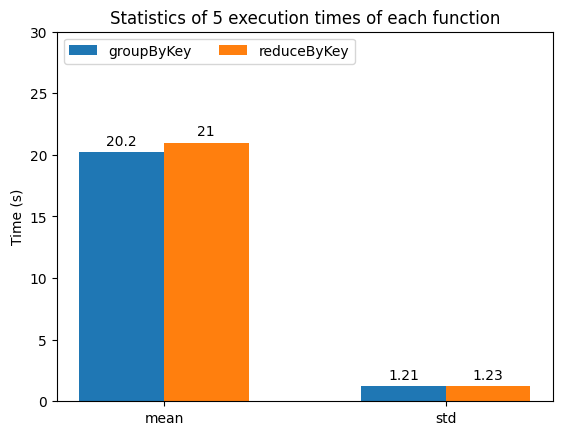

In [15]:
# 20.2 s ± 1.21 s
# 21 s ± 1.23 s

stats = ['mean', 'std']

exec_query_data = {
    'groupByKey': [20.2, 1.21],
    'reduceByKey': [21, 1.23]
}

x = np.arange(len(stats))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for key, values in exec_query_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=key)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Statistics of 5 execution times of each function')
ax.set_xticks(x + width / 2, stats)

ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 30)

plt.show()